# Lab 8 - Feature Selection and Principal Component Analysis (PCA)

Here, we will analyze the impact of dimensionality by running one model with some selected features and then with some extracted features. The model selected is Gradient Boosting with the estimators considered the "best" on the lab_05 tests, because it gave us the best results so far.

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_selection import chi2, f_classif, mutual_info_classif, SelectKBest
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from utils import modelAnalyzesFunctions as analyzes, graphFunctions as graph
import sklearn.metrics as metrics
from sklearn.decomposition import PCA

In [3]:
data_9: pd.DataFrame = pd.read_csv('../datasets/pd_data_preparation_9.csv', sep=',', decimal='.', index_col='id')
y_9: np.ndarray = data_9.pop('class').values
X_9: np.ndarray = data_9.values
labels_9 = pd.unique(y_9)

data_9.head()

,gender,PPE,DFA,RPDE,numPulses,stdDevPeriodPulses,locPctJitter,locShimmer,meanAutoCorrHarmonicity,meanHarmToNoiseHarmonicity,...,tqwt_kurtosisValue_dec_23,tqwt_kurtosisValue_dec_24,tqwt_kurtosisValue_dec_25,tqwt_kurtosisValue_dec_26,tqwt_kurtosisValue_dec_27,tqwt_kurtosisValue_dec_28,tqwt_kurtosisValue_dec_29,tqwt_kurtosisValue_dec_30,tqwt_kurtosisValue_dec_34,tqwt_kurtosisValue_dec_36
id,,,,,,,,,,,,,,,,,,,,,
0,1.0,0.916232,0.475707,0.590235,0.284974,0.022323,0.075900,0.271284,0.944323,0.626765,...,0.013066,0.004055,0.003293,0.000374,0.000178,0.000191,0.008863,0.098628,0.031079,0.218287
1,0.0,0.182314,0.806469,0.630075,0.242228,0.689703,0.247423,0.228818,0.876238,0.577781,...,0.038398,0.008310,0.001114,0.001689,0.024783,0.018258,0.022440,0.040204,0.058074,0.017145
2,1.0,0.877689,0.216841,0.516437,0.448187,0.033848,0.087255,0.117413,0.974092,0.665577,...,0.007834,0.019385,0.000201,0.000368,0.000336,0.213153,0.204655,0.120303,0.125812,0.028947
3,0.0,0.925807,0.237611,0.542708,0.785622,0.010547,0.021814,0.161006,0.983185,0.775315,...,0.037870,0.020783,0.009404,0.018881,0.003916,0.000815,0.002275,0.009216,0.015696,0.216241
4,0.0,0.930451,0.757013,0.842307,0.532383,0.754983,0.148962,0.722861,0.734980,0.314902,...,0.022389,0.009184,0.006695,0.009538,0.010617,0.013877,0.018696,0.010267,0.090744,0.662076



## Feature Selection

In [4]:
selector_chi = SelectKBest(chi2, k=2)
X_new = selector_chi.fit_transform(X_9, y_9)
data_9.columns[selector_chi.get_support()]

Index(['tqwt_kurtosisValue_dec_26', 'tqwt_kurtosisValue_dec_36'], dtype='object')

In [5]:
selector_f = SelectKBest(f_classif, k=2)
X_new = selector_f.fit_transform(X_9, y_9)
data_9.columns[selector_f.get_support()]

Index(['std_8th_delta', 'std_9th_delta'], dtype='object')

In [6]:
selector_mut = SelectKBest(mutual_info_classif, k=2)
X_new = selector_mut.fit_transform(X_9, y_9)
data_9.columns[selector_mut.get_support()]

Index(['maxIntensity', 'std_9th_delta'], dtype='object')

In [7]:
## gradient boosting parameters
max_depth = 3
n_estimators = 250
learning_rate = 0.3
max_features = 'sqrt'

n_splits = 4
n_repeats = 3

rskf = RepeatedStratifiedKFold(n_splits, n_repeats, random_state=42)

accuracy_gb, sensitivity_gb = analyzes.gradient_boosting(X_9, y_9, rskf, learning_rate=learning_rate, n_estimators=n_estimators, max_depth=max_depth, max_features=max_features)
print("Best accuracy: ", accuracy_gb)
print("Best sensitivity: ", sensitivity_gb)

Best accuracy:  0.9237588652482268
Best sensitivity:  0.9095744680851064


In [8]:
def gradient_boosting_with_n_features(X, y, rskf, learning_rate, n_estimators, max_depth, max_features, n_features, estimator):
    accuracies = np.zeros(len(n_features))
    sensitivities = np.zeros(len(n_features))
    for n in range(len(n_features)):
        selector = SelectKBest(estimator, k=n_features[n])
        X_new = selector.fit_transform(X, y)
        acc, sens = analyzes.gradient_boosting(X_new, y, rskf, learning_rate=learning_rate, n_estimators=n_estimators, max_depth=max_depth, max_features=max_features)
        accuracies[n] = acc
        sensitivities[n] = sens
    return accuracies, sensitivities

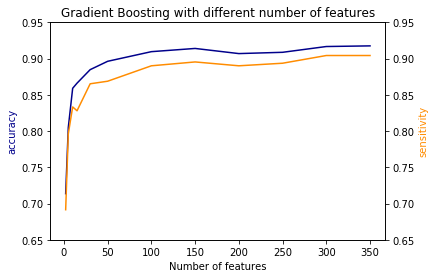

Best accuracy: 0.9175531914893619
Sensitivity associated: 0.9042553191489362
Number of features 350 

Best sensitivity: 0.9042553191489362
Accuracy associated: 0.9175531914893619
Number of features 350 



In [9]:
n_features = [2, 5, 10, 15, 30, 50, 100, 150, 200, 250, 300, 350]

rskf = RepeatedStratifiedKFold(n_splits, n_repeats, random_state=42)

accuracies_gb_chi, sensitivities_gb_chi = gradient_boosting_with_n_features(X_9, y_9, rskf, learning_rate, n_estimators, max_depth, max_features, n_features, chi2)

plt.figure()
graph.double_line_chart_different_scales(plt.gca(), n_features, accuracies_gb_chi, sensitivities_gb_chi, 'Gradient Boosting with different number of features', 'Number of features', 'accuracy', 'sensitivity', y_interval=(0.65, 0.95), y_interval2=(0.65, 0.95))
plt.show()
print("Best accuracy:", np.max(accuracies_gb_chi))
print("Sensitivity associated:", sensitivities_gb_chi[np.argmax(accuracies_gb_chi)])
print("Number of features", n_features[np.argmax(accuracies_gb_chi)], '\n')
print("Best sensitivity:", np.max(sensitivities_gb_chi))
print("Accuracy associated:", accuracies_gb_chi[np.argmax(sensitivities_gb_chi)])
print("Number of features", n_features[np.argmax(sensitivities_gb_chi)], '\n')

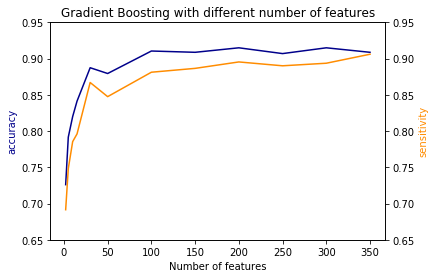

Best accuracy: 0.9148936170212766
Sensitivity associated: 0.8953900709219859
Number of features 200 

Best sensitivity: 0.9060283687943262
Accuracy associated: 0.9086879432624113
Number of features 350 



In [10]:
rskf = RepeatedStratifiedKFold(n_splits, n_repeats, random_state=42)

accuracies_gb_f, sensitivities_gb_f = gradient_boosting_with_n_features(X_9, y_9, rskf, learning_rate, n_estimators, max_depth, max_features, n_features, f_classif)

plt.figure()
graph.double_line_chart_different_scales(plt.gca(), n_features, accuracies_gb_f, sensitivities_gb_f, 'Gradient Boosting with different number of features', 'Number of features', 'accuracy', 'sensitivity', y_interval=(0.65, 0.95), y_interval2=(0.65, 0.95))
plt.show()
print("Best accuracy:", np.max(accuracies_gb_f))
print("Sensitivity associated:", sensitivities_gb_f[np.argmax(accuracies_gb_f)])
print("Number of features", n_features[np.argmax(accuracies_gb_f)], '\n')
print("Best sensitivity:", np.max(sensitivities_gb_f))
print("Accuracy associated:", accuracies_gb_f[np.argmax(sensitivities_gb_f)])
print("Number of features", n_features[np.argmax(sensitivities_gb_f)], '\n')

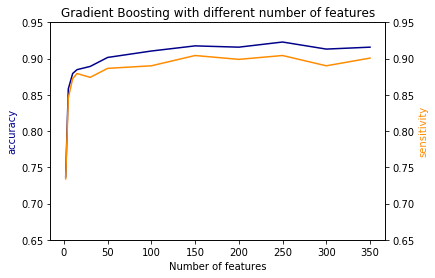

Best accuracy: 0.9228723404255321
Sensitivity associated: 0.9042553191489362
Number of features 250 

Best sensitivity: 0.9042553191489362
Accuracy associated: 0.9175531914893617
Number of features 150 



In [11]:
rskf = RepeatedStratifiedKFold(n_splits, n_repeats, random_state=42)

accuracies_gb_mut, sensitivities_gb_mut = gradient_boosting_with_n_features(X_9, y_9, rskf, learning_rate, n_estimators, max_depth, max_features, n_features, mutual_info_classif)

plt.figure()
graph.double_line_chart_different_scales(plt.gca(), n_features, accuracies_gb_mut, sensitivities_gb_mut, 'Gradient Boosting with different number of features', 'Number of features', 'accuracy', 'sensitivity', y_interval=(0.65, 0.95), y_interval2=(0.65, 0.95))
plt.show()
print("Best accuracy:", np.max(accuracies_gb_mut))
print("Sensitivity associated:", sensitivities_gb_mut[np.argmax(accuracies_gb_mut)])
print("Number of features", n_features[np.argmax(accuracies_gb_mut)], '\n')
print("Best sensitivity:", np.max(sensitivities_gb_mut))
print("Accuracy associated:", accuracies_gb_mut[np.argmax(sensitivities_gb_mut)])
print("Number of features", n_features[np.argmax(sensitivities_gb_mut)], '\n')

After reaching around 100 variables, the metrics don't change much, therefore it's possible to use something around this number for this emsemble model. But, since ensemble models use the idea of combing multiple independent and diverse models, it makes sense that a lot of features results in better results. To try this hypothesis, the next test will be vary the number of features with KNN (N=1, because it got the best result on the lab_03 tests).

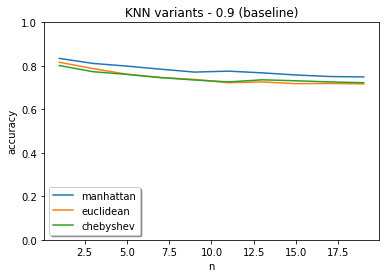

Accuracy for n equal to 1 : 0.8342
Sensitivity for n equal to 1 : 0.6809 

Accuracy for n equal to 3 : 0.8112
Sensitivity for n equal to 3 : 0.6454 

Accuracy for n equal to 5 : 0.7988
Sensitivity for n equal to 5 : 0.6206 

Accuracy for n equal to 7 : 0.7846
Sensitivity for n equal to 7 : 0.5993 

Accuracy for n equal to 9 : 0.7713
Sensitivity for n equal to 9 : 0.5833 

Accuracy for n equal to 11 : 0.7757
Sensitivity for n equal to 11 : 0.5904 

Accuracy for n equal to 13 : 0.7677
Sensitivity for n equal to 13 : 0.5833 

Accuracy for n equal to 15 : 0.7580
Sensitivity for n equal to 15 : 0.5816 

Accuracy for n equal to 17 : 0.7509
Sensitivity for n equal to 17 : 0.5833 

Accuracy for n equal to 19 : 0.7491
Sensitivity for n equal to 19 : 0.5851 



In [12]:
nvalues = [1, 3, 5, 7, 9, 11, 13, 15, 17, 19]
dist = ['manhattan', 'euclidean', 'chebyshev']

rskf = RepeatedStratifiedKFold(n_splits, n_repeats, random_state=42)

accuracy_knn, sensitivity_knn = analyzes.knn_analyzes(X_9, y_9, nvalues, dist, rskf, title_complement = '- 0.9 (baseline)')

In [13]:
def knn_with_n_features(X, y, nvalue, dist, rskf, n_features, estimator):
    accuracies = np.zeros(len(n_features))
    sensitivities = np.zeros(len(n_features))
    for n in range(len(n_features)):
        selector = SelectKBest(estimator, k=n_features[n])
        X_new = selector.fit_transform(X, y)
        acc, sens = analyzes.knn(X_new, y, nvalue, dist, rskf)
        accuracies[n] = acc
        sensitivities[n] = sens
    return accuracies, sensitivities

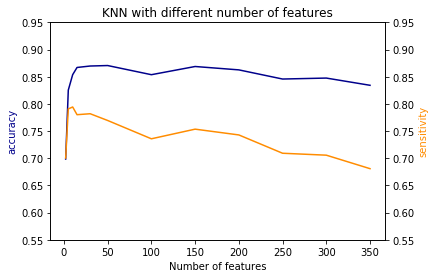

Best accuracy: 0.8705673758865249
Sensitivity associated: 0.7695035460992908
Number of features 50 

Best sensitivity: 0.7943262411347519
Accuracy associated: 0.8537234042553191
Number of features 10 



In [14]:
n_features = [2, 5, 10, 15, 30, 50, 100, 150, 200, 250, 300, 350]

nvalue = 1
dist = 'manhattan'

rskf = RepeatedStratifiedKFold(n_splits, n_repeats, random_state=42)

accuracies_knn_chi, sensitivities_knn_chi = knn_with_n_features(X_9, y_9, nvalue, dist, rskf, n_features, chi2)

plt.figure()
graph.double_line_chart_different_scales(plt.gca(), n_features, accuracies_knn_chi, sensitivities_knn_chi, 'KNN with different number of features', 'Number of features', 'accuracy', 'sensitivity', y_interval=(0.55, 0.95), y_interval2=(0.55, 0.95))
plt.show()
print("Best accuracy:", np.max(accuracies_knn_chi))
print("Sensitivity associated:", sensitivities_knn_chi[np.argmax(accuracies_knn_chi)])
print("Number of features", n_features[np.argmax(accuracies_knn_chi)], '\n')
print("Best sensitivity:", np.max(sensitivities_knn_chi))
print("Accuracy associated:", accuracies_knn_chi[np.argmax(sensitivities_knn_chi)])
print("Number of features", n_features[np.argmax(sensitivities_knn_chi)], '\n')

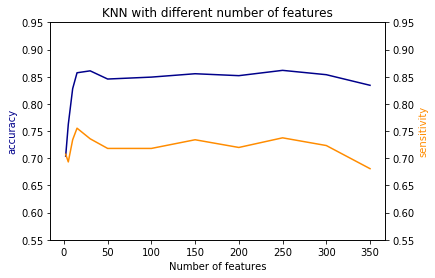

Best accuracy: 0.8617021276595745
Sensitivity associated: 0.7375886524822696
Number of features 250 

Best sensitivity: 0.7553191489361702
Accuracy associated: 0.8572695035460994
Number of features 15 



In [15]:
rskf = RepeatedStratifiedKFold(n_splits, n_repeats, random_state=42)

accuracies_knn_f, sensitivities_knn_f = knn_with_n_features(X_9, y_9, nvalue, dist, rskf, n_features, f_classif)

plt.figure()
graph.double_line_chart_different_scales(plt.gca(), n_features, accuracies_knn_f, sensitivities_knn_f, 'KNN with different number of features', 'Number of features', 'accuracy', 'sensitivity', y_interval=(0.55, 0.95), y_interval2=(0.55, 0.95))
plt.show()
print("Best accuracy:", np.max(accuracies_knn_f))
print("Sensitivity associated:", sensitivities_knn_f[np.argmax(accuracies_knn_f)])
print("Number of features", n_features[np.argmax(accuracies_knn_f)], '\n')
print("Best sensitivity:", np.max(sensitivities_knn_f))
print("Accuracy associated:", accuracies_knn_f[np.argmax(sensitivities_knn_f)])
print("Number of features", n_features[np.argmax(sensitivities_knn_f)], '\n')

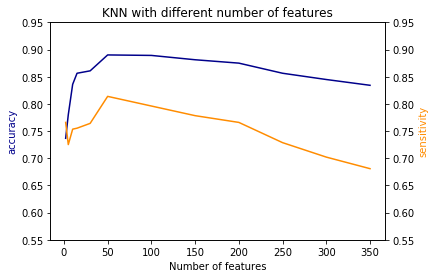

Best accuracy: 0.8900709219858155
Sensitivity associated: 0.8138297872340425
Number of features 50 

Best sensitivity: 0.8138297872340425
Accuracy associated: 0.8900709219858155
Number of features 50 



In [16]:
rskf = RepeatedStratifiedKFold(n_splits, n_repeats, random_state=42)

accuracies_knn_mut, sensitivities_knn_mut = knn_with_n_features(X_9, y_9, nvalue, dist, rskf, n_features, mutual_info_classif)

plt.figure()
graph.double_line_chart_different_scales(plt.gca(), n_features, accuracies_knn_mut, sensitivities_knn_mut, 'KNN with different number of features', 'Number of features', 'accuracy', 'sensitivity', y_interval=(0.55, 0.95), y_interval2=(0.55, 0.95))
plt.show()
print("Best accuracy:", np.max(accuracies_knn_mut))
print("Sensitivity associated:", sensitivities_knn_mut[np.argmax(accuracies_knn_mut)])
print("Number of features", n_features[np.argmax(accuracies_knn_mut)], '\n')
print("Best sensitivity:", np.max(sensitivities_knn_mut))
print("Accuracy associated:", accuracies_knn_mut[np.argmax(sensitivities_knn_mut)])
print("Number of features", n_features[np.argmax(sensitivities_knn_mut)], '\n')

As we mentioned, KNN didn't behave as the gradiant boosting, it even presented a decreasing sensitivity with higher values of features. This is often mencioned as the "curse of dimensionality", because with the increase of dimensions (features), the number of data records to represent all space grows exponencially.

## PCA

There will be created enough components to explain around 85% of the dataset variation (commonly used number of cumulative percentage explained for PCA).

In [17]:
pca = PCA(n_components=0.85, svd_solver="full")
pca.fit(X_9)

X_pca = pca.transform(X_9)

print("Explained variance (ratio) =",pca.explained_variance_ratio_)
print("Number of features extracted =", len(pca.explained_variance_ratio_))
print("Total explained variance =", np.sum(pca.explained_variance_ratio_))

Explained variance (ratio) = [0.15216498 0.0910425  0.05575017 0.05224917 0.03842408 0.03405618
 0.02610794 0.02463169 0.02107328 0.02037562 0.01852077 0.01762006
 0.01618874 0.01437347 0.01389749 0.01209213 0.01169139 0.01061298
 0.01034962 0.00956988 0.00937208 0.00913938 0.00852757 0.00833343
 0.00788608 0.00779839 0.00751972 0.00715467 0.00679778 0.00673504
 0.00642866 0.0062232  0.00605935 0.0059519  0.00574814 0.00568707
 0.00547277 0.00511924 0.00497882 0.00486822 0.00479044 0.00471937
 0.00460359 0.00446634 0.00441054 0.00433889 0.00408039 0.00403255
 0.00393521 0.00384788 0.00372245 0.00367916 0.00348446 0.00341682
 0.00334496 0.00327483]
Number of features extracted = 56
Total explained variance = 0.8507415298889401


In [18]:
rskf = RepeatedStratifiedKFold(n_splits, n_repeats, random_state=42)

accuracy_pca_gb, sensitivity_pca_gb = analyzes.gradient_boosting(X_pca, y_9, rskf, learning_rate=learning_rate, n_estimators=n_estimators, max_depth=max_depth, max_features=max_features)

print("Accuracy:", accuracy_pca_gb)
print("Sensitivity:", sensitivity_pca_gb)

Accuracy: 0.897163120567376
Sensitivity: 0.8829787234042553


The result was really similar to Gradient Boosting with the same number of features.

In [19]:
rskf = RepeatedStratifiedKFold(n_splits, n_repeats, random_state=42)

accuracy_pca_knn, sensitivity_pca_knn = knn(X_pca, y_9, nvalue, dist, rskf)

print("Accuracy:", accuracy_pca_knn)
print("Sensitivity:", sensitivity_pca_knn)

NameError: name 'knn' is not defined

The result was really similar to KNN with the same number of features selected by the criterion with highest accuracy.